## 1. Importación de librerías y configuración

En esta sección se importan las librerías necesarias para el análisis de datos, visualización y manejo de advertencias. Además, se configura el estilo de los gráficos para asegurar una presentación visual profesional y se suprimen advertencias irrelevantes para mantener el notebook limpio.

In [24]:
# Importación de librerías necesarias para el análisis de datos y visualización
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests

# Configuración de estilo para gráficos y supresión de advertencias irrelevantes
sns.set(style="whitegrid", palette="muted")
warnings.filterwarnings('ignore')

## 2. Carga, limpieza y transformación de los datos

Se cargan los datos desde una fuente externa, se normalizan y renombran las columnas para mayor claridad. Posteriormente, se transforman variables categóricas a formato numérico binario, se crean nuevas variables útiles para el análisis y se eliminan registros con valores nulos en las columnas clave. Este proceso garantiza que los datos estén listos para un análisis exploratorio robusto.

In [29]:
# Carga de datos desde un archivo JSON alojado en GitHub
url = "https://raw.githubusercontent.com/alura-cursos/challenge2-data-science-LATAM/refs/heads/main/TelecomX_Data.json"
response = requests.get(url)
response.raise_for_status()
json_data = response.json()

# Normalización y conversión a DataFrame
df = pd.json_normalize(json_data, sep='_')

# Renombrado de columnas para mayor claridad y consistencia
def clean_column_names(col):
    for prefix in ['customer_', 'internet_', 'phone_', 'account_']:
        if col.startswith(prefix):
            return col.replace(prefix, '')
    return col

df.columns = [clean_column_names(col).lower() for col in df.columns]

# Conversión de variables categóricas a formato numérico binario
binary_columns = [
    'churn', 'partner', 'dependents', 'onlinesecurity', 'onlinebackup',
    'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
    'paperlessbilling', 'phoneservice', 'multiplelines'
]
for col in binary_columns:
    df[col] = df[col].replace({'Yes': 1, 'No': 0})

# Conversión de la columna 'charges_total' a numérico, manejando errores
df['charges_total'] = pd.to_numeric(df['charges_total'], errors='coerce')

# Creación de una nueva columna para el cargo diario promedio
df['charges_daily'] = df['charges_monthly'] / 30

# Eliminación de filas con valores nulos en 'charges_total' para análisis numéricos
df_cleaned = df.dropna(subset=['charges_total']).copy()

## 3. Análisis exploratorio: Distribución de Churn

En esta sección se visualiza la distribución de clientes que han abandonado la empresa (churn) frente a los que permanecen. Se utilizan gráficos de barras y de pastel para comprender la proporción y cantidad de clientes en cada grupo, lo que permite dimensionar el problema de la evasión.

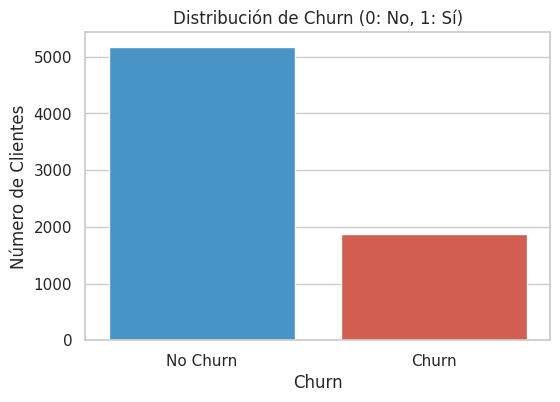

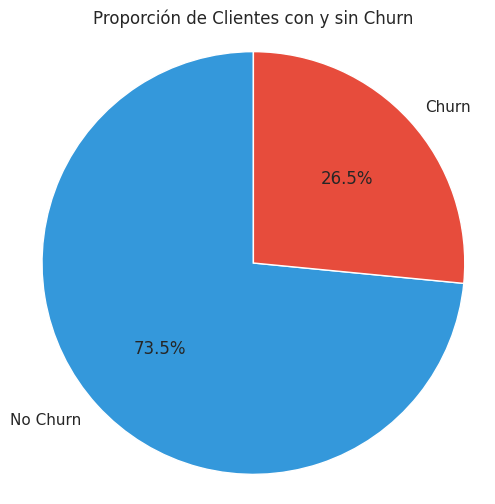

In [30]:
plt.figure(figsize=(6, 4))
df['churn'] = pd.to_numeric(df['churn'].replace({'Yes': 1, 'No': 0}), errors='coerce')
df.dropna(subset=['churn'], inplace=True)
churn_counts = df['churn'].value_counts().sort_index()
sns.barplot(x=churn_counts.index, y=churn_counts.values, palette=['#3498db', '#e74c3c'])
plt.title('Distribución de Churn (0: No, 1: Sí)')
plt.xlabel('Churn')
plt.ylabel('Número de Clientes')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

# Gráfico de pastel para proporción de churn
plt.figure(figsize=(6, 6))
plt.pie(churn_counts, labels=['No Churn', 'Churn'], autopct='%1.1f%%', startangle=90, colors=['#3498db', '#e74c3c'])
plt.title('Proporción de Clientes con y sin Churn')
plt.axis('equal')
plt.show()

## 4. Análisis exploratorio: Variables categóricas

Aquí se analiza la relación entre la evasión de clientes (churn) y diferentes variables categóricas, como género, tipo de contrato, servicios contratados y método de pago. Se emplean gráficos de barras segmentados para identificar patrones y diferencias en la tasa de churn según cada categoría.

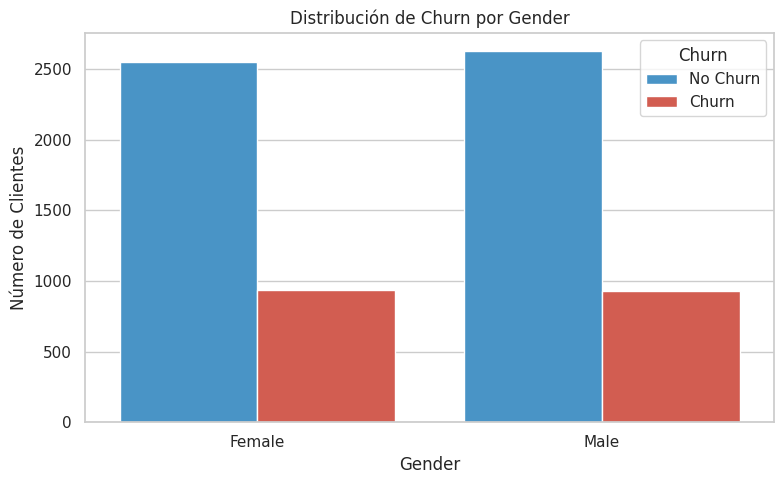

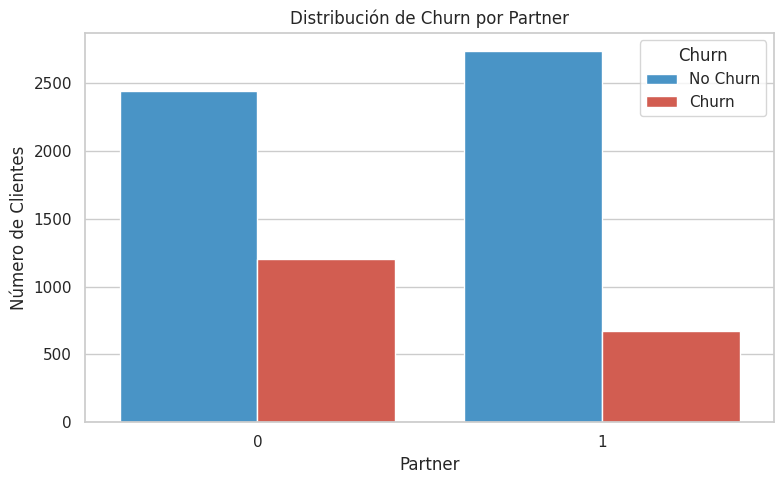

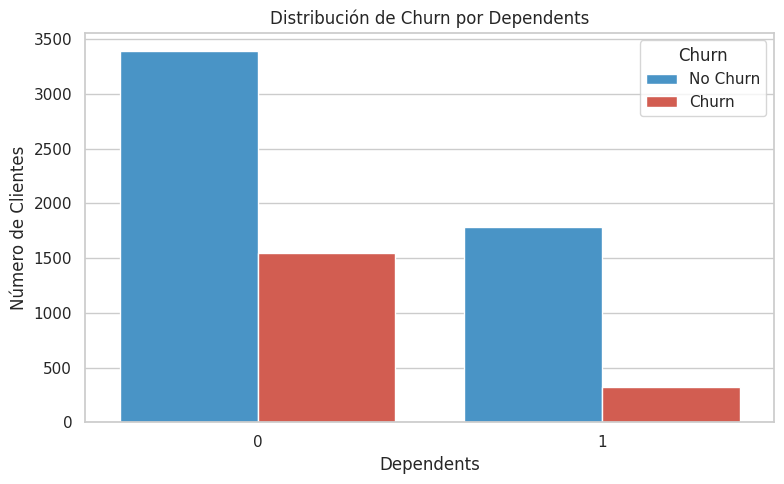

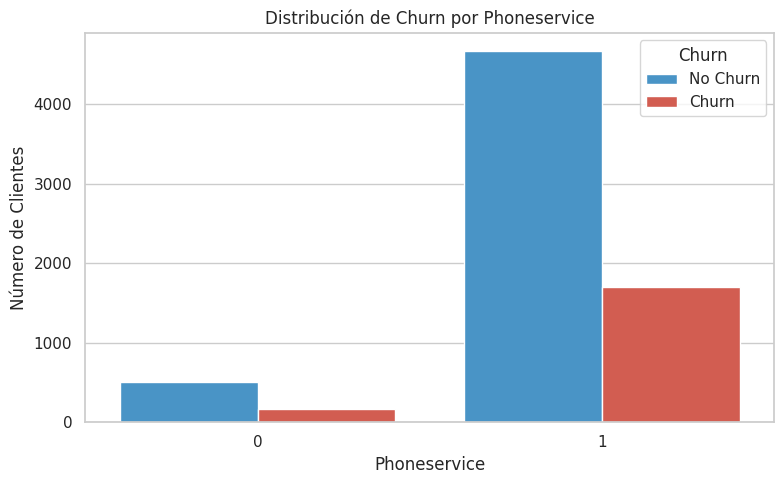

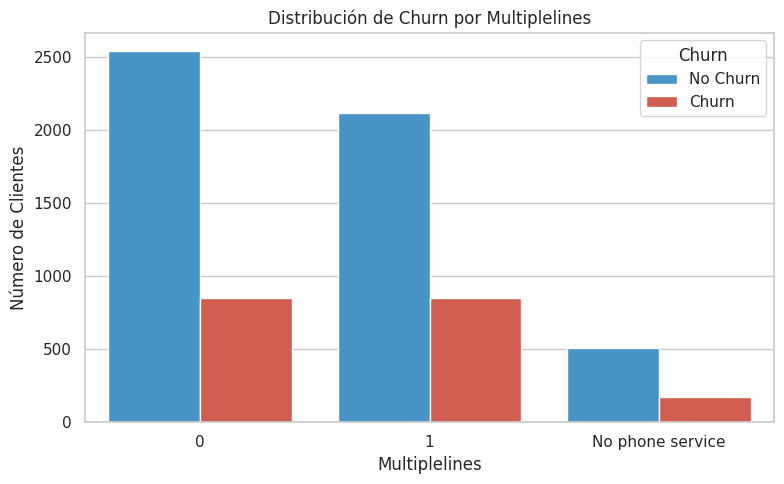

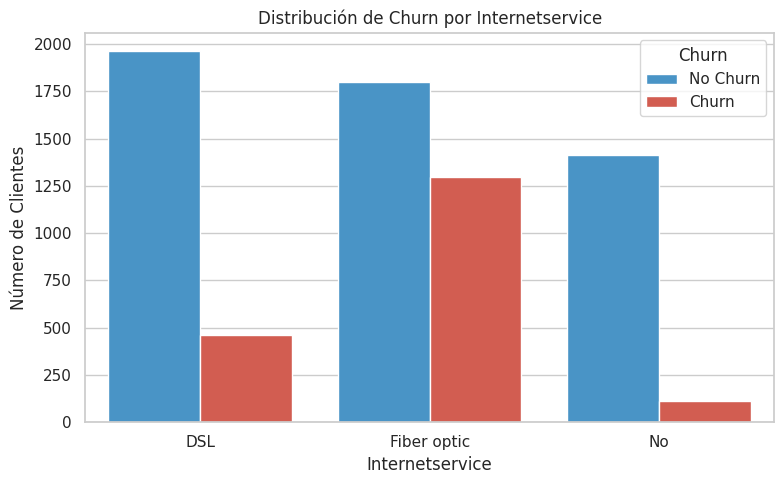

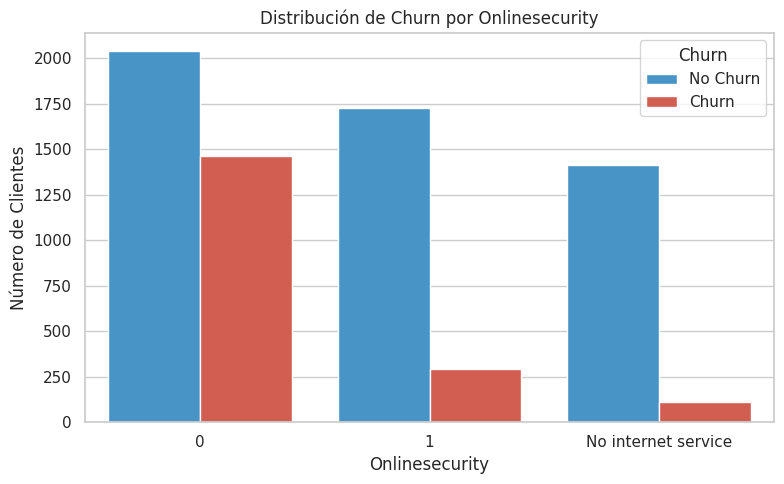

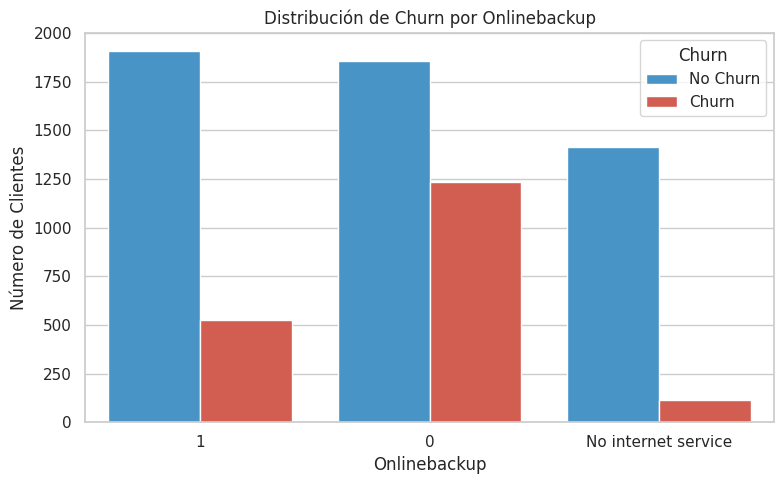

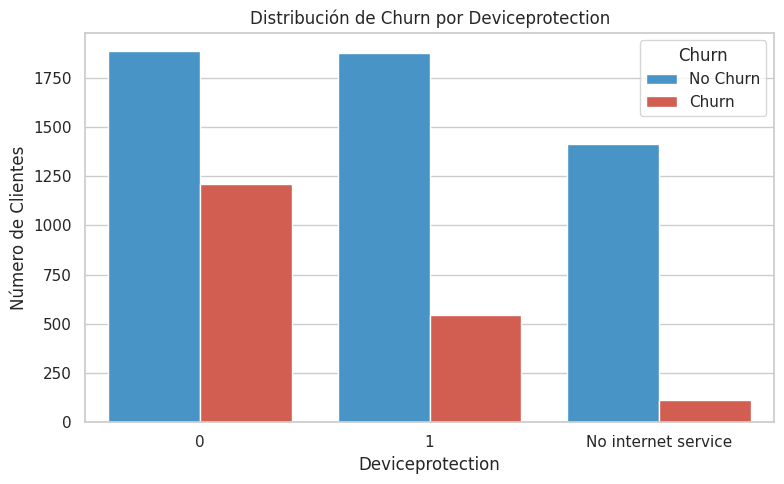

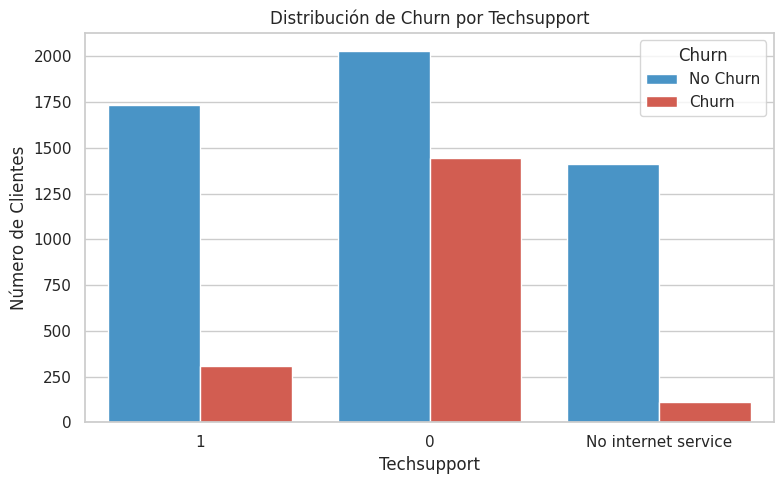

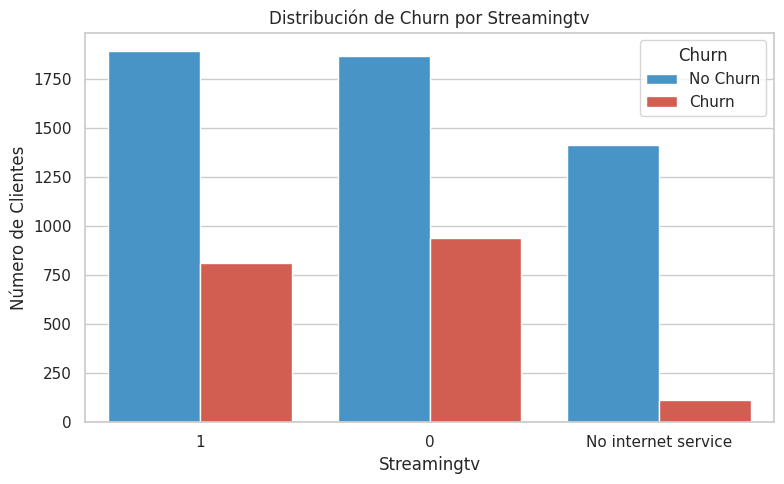

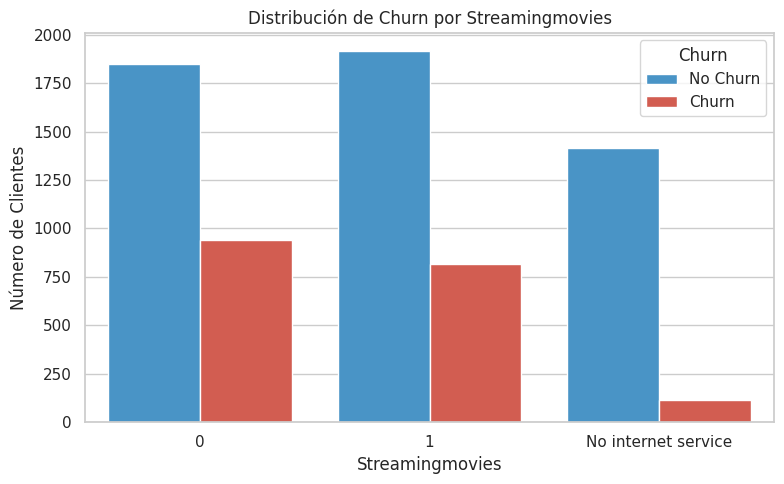

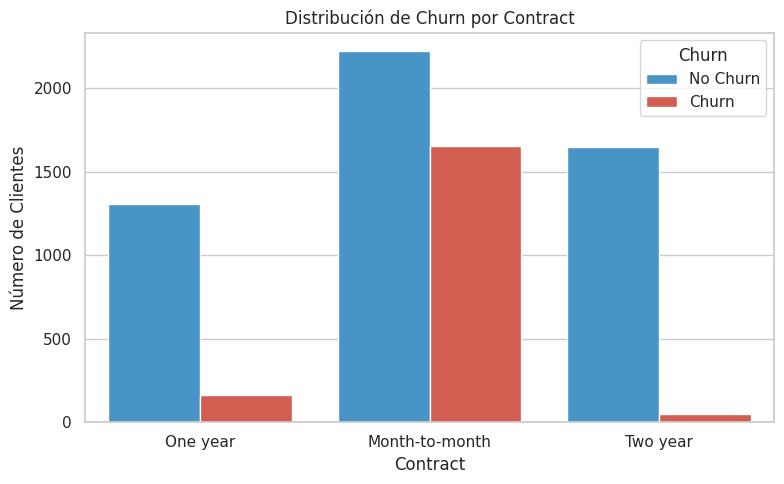

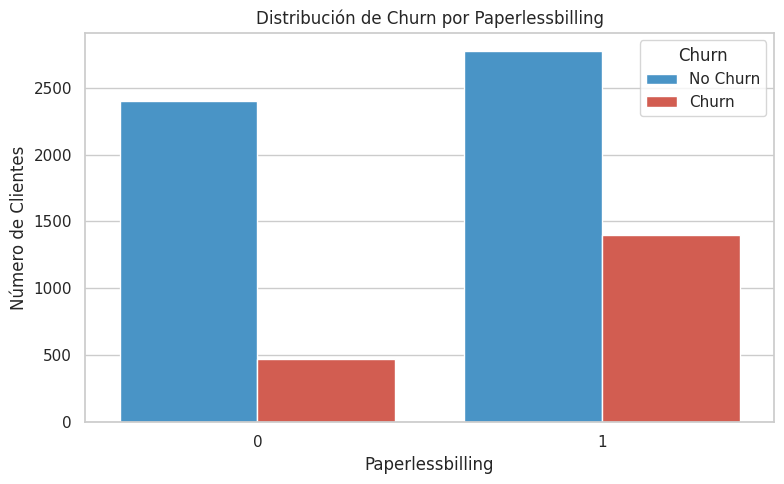

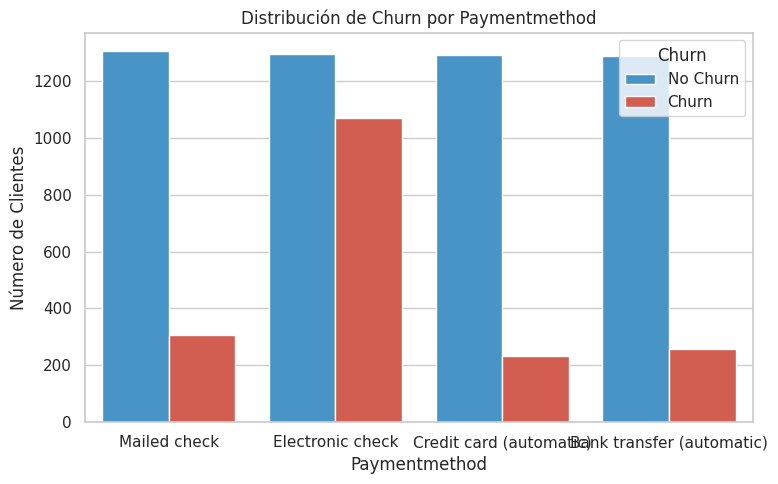

In [31]:
# Análisis de la relación entre churn y variables categóricas
categorical_cols = [
    'gender', 'partner', 'dependents', 'phoneservice', 'multiplelines',
    'internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingtv', 'streamingmovies', 'contract',
    'paperlessbilling', 'paymentmethod'
]

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, hue='churn', palette=['#3498db', '#e74c3c'])
    plt.title(f'Distribución de Churn por {col.capitalize()}')
    plt.xlabel(col.capitalize())
    plt.ylabel('Número de Clientes')
    plt.legend(title='Churn', labels=['No Churn', 'Churn'])
    plt.tight_layout()
    plt.show()

## 5. Análisis exploratorio: Variables numéricas

En esta sección se explora cómo las variables numéricas, como la antigüedad del cliente y los cargos mensuales o totales, se relacionan con la evasión. Se utilizan boxplots e histogramas para comparar la distribución de estas variables entre clientes que permanecen y los que han abandonado la empresa, identificando posibles factores de riesgo.

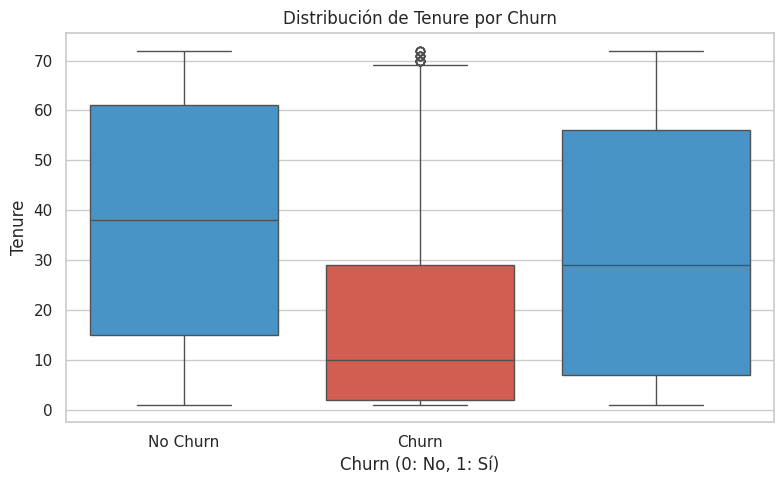

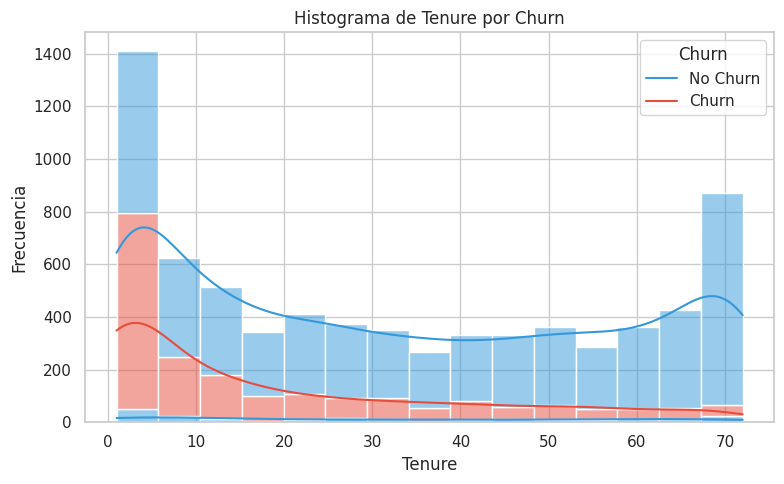

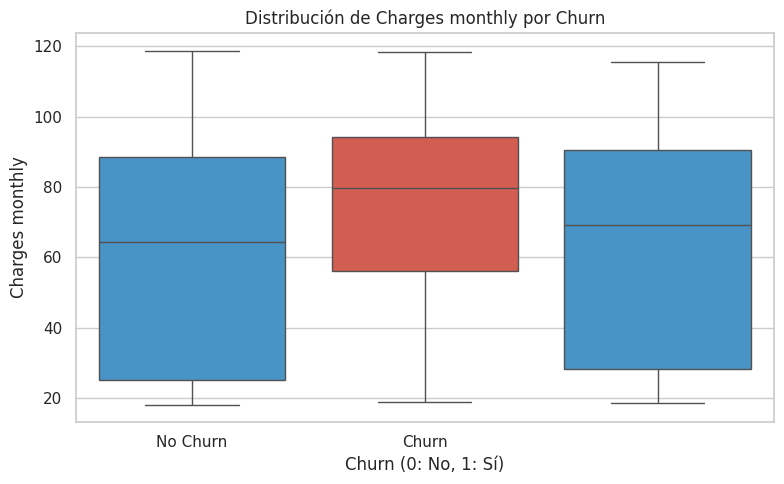

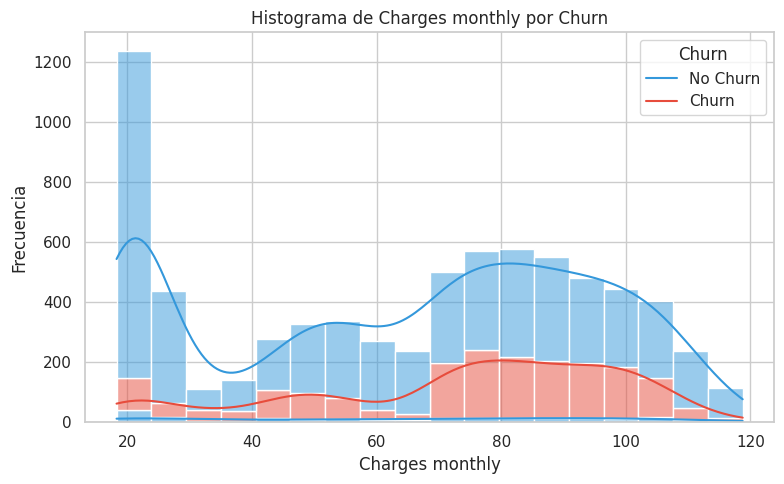

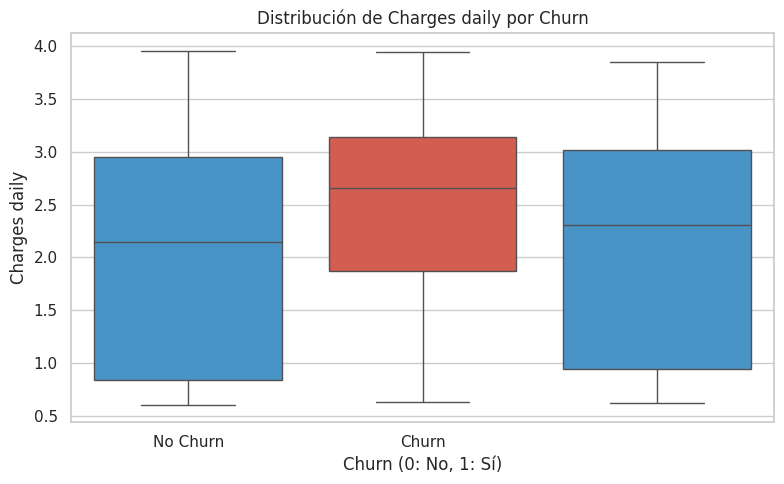

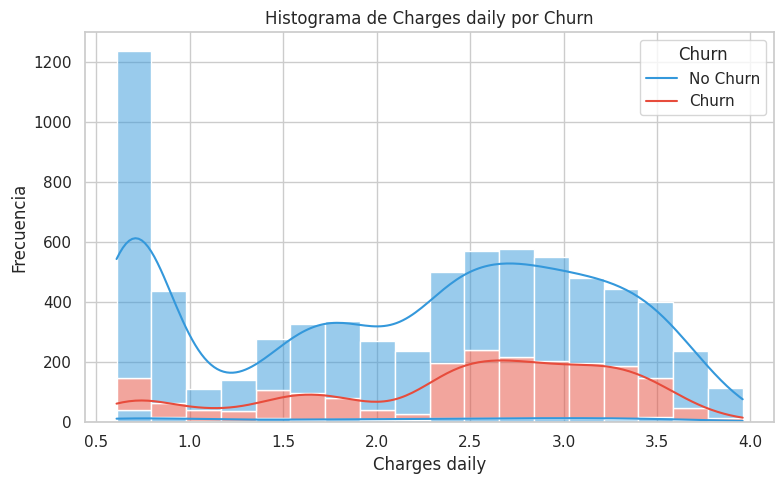

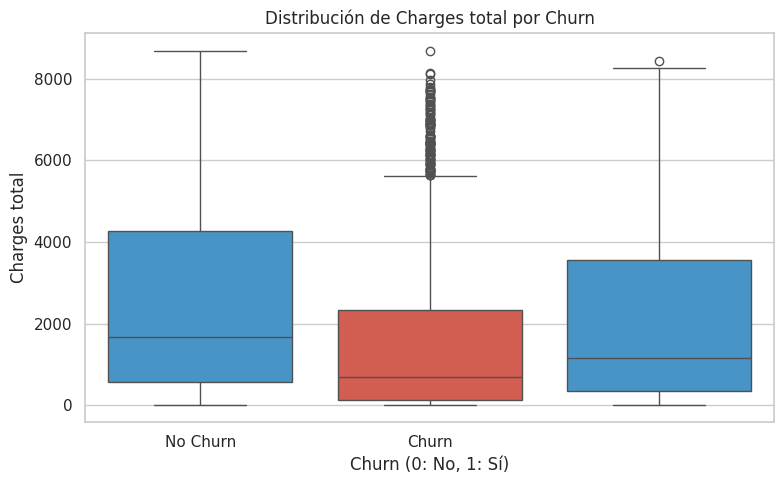

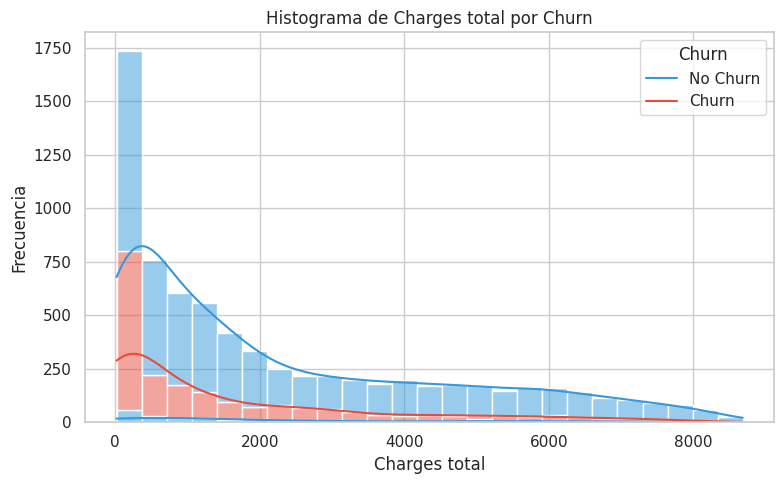

In [32]:
# Análisis de la relación entre churn y variables numéricas
numeric_cols = ['tenure', 'charges_monthly', 'charges_daily', 'charges_total']

for col in numeric_cols:
    if col in df_cleaned.columns:
        # Este bloque de código ahora está indentado correctamente
        plt.figure(figsize=(8, 5))
        sns.boxplot(data=df_cleaned, x='churn', y=col, palette=['#3498db', '#e74c3c'])
        plt.title(f'Distribución de {col.replace("_", " ").capitalize()} por Churn')
        plt.xlabel('Churn (0: No, 1: Sí)')
        plt.ylabel(col.replace('_', ' ').capitalize())
        plt.xticks([0, 1], ['No Churn', 'Churn'])
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 5))
        sns.histplot(data=df_cleaned, x=col, hue='churn', multiple='stack', kde=True, palette=['#3498db', '#e74c3c'])
        plt.title(f'Histograma de {col.replace("_", " ").capitalize()} por Churn')
        plt.xlabel(col.replace('_', ' ').capitalize())
        plt.ylabel('Frecuencia')
        plt.legend(title='Churn', labels=['No Churn', 'Churn'])
        plt.tight_layout()
        plt.show()

# 📄 Informe Final: Análisis de Evasión de Clientes (Churn) en TelecomX

## 1. Introducción

El objetivo de este análisis es comprender los factores que influyen en la evasión de clientes (churn) en la empresa TelecomX. El churn representa la pérdida de clientes, un problema crítico para las empresas de telecomunicaciones, ya que retener clientes existentes suele ser más rentable que adquirir nuevos. Identificar patrones y variables asociadas al churn permite diseñar estrategias efectivas para reducir la fuga de clientes y mejorar la rentabilidad.

## 2. Limpieza y Tratamiento de Datos

- **Importación:** Se importaron los datos desde un archivo JSON alojado en GitHub.
- **Normalización:** Se normalizaron los datos y se renombraron las columnas para mayor claridad.
- **Conversión de variables:** Se transformaron variables categóricas (como 'Yes'/'No') a valores binarios (1/0) para facilitar el análisis.
- **Creación de variables:** Se creó la variable `charges_daily` para analizar el gasto diario promedio.
- **Manejo de valores nulos:** Se identificaron y trataron valores nulos, especialmente en la columna `charges_total`, convirtiéndola a formato numérico y eliminando filas con datos faltantes para ciertos análisis.

## 3. Análisis Exploratorio de Datos

- **Distribución de Churn:** Se observó que aproximadamente el 26% de los clientes han abandonado la empresa.
- **Variables categóricas:** Se analizaron variables como género, tipo de contrato, servicios contratados, y métodos de pago. Se identificaron diferencias notables en la tasa de churn según el tipo de contrato y la presencia de servicios adicionales (seguridad en línea, soporte técnico, etc.).
- **Variables numéricas:** Se exploró la relación entre el churn y variables como la antigüedad del cliente (`tenure`) y los cargos mensuales/totales. Los clientes con menor antigüedad y cargos mensuales más altos tienden a presentar mayor churn.

## 4. Conclusiones e Insights

- **Antigüedad:** Los clientes con menor tiempo en la empresa son más propensos a abandonar el servicio.
- **Tipo de contrato:** Los contratos mensuales presentan una tasa de churn significativamente mayor que los contratos a largo plazo.
- **Servicios adicionales:** La ausencia de servicios como seguridad en línea, respaldo o soporte técnico está asociada a una mayor evasión.
- **Cargos mensuales:** Los clientes con cargos mensuales elevados tienden a abandonar más, posiblemente por percibir un menor valor por el costo.

## 5. Recomendaciones

- **Fomentar contratos a largo plazo:** Ofrecer incentivos para que los clientes opten por contratos anuales o bianuales puede reducir el churn.
- **Promocionar servicios adicionales:** Incluir servicios de seguridad, respaldo y soporte técnico en los paquetes básicos o a precios promocionales puede aumentar la retención.
- **Estrategias para nuevos clientes:** Implementar programas de bienvenida y seguimiento personalizado durante los primeros meses puede disminuir la fuga temprana.
- **Revisión de precios:** Analizar la estructura de precios para clientes con cargos mensuales altos y ofrecer descuentos o beneficios adicionales.
- **Alertas tempranas:** Desarrollar modelos predictivos para identificar clientes en riesgo y aplicar acciones preventivas.

# ADICIONALES

### 6. Análisis de correlación entre variables

En esta sección se exploran las correlaciones entre diferentes variables del dataset para identificar los factores que tienen mayor relación con la evasión de clientes (churn). Se analiza, por ejemplo, la relación entre el gasto diario y la evasión, así como el impacto de la cantidad de servicios contratados en la probabilidad de churn. Este análisis es fundamental para obtener insights que permitan construir modelos predictivos más robustos.

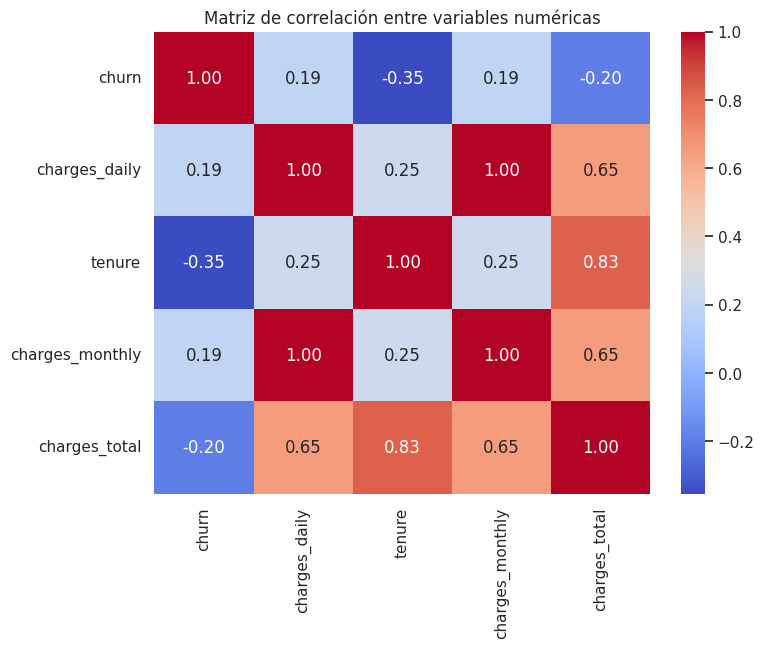

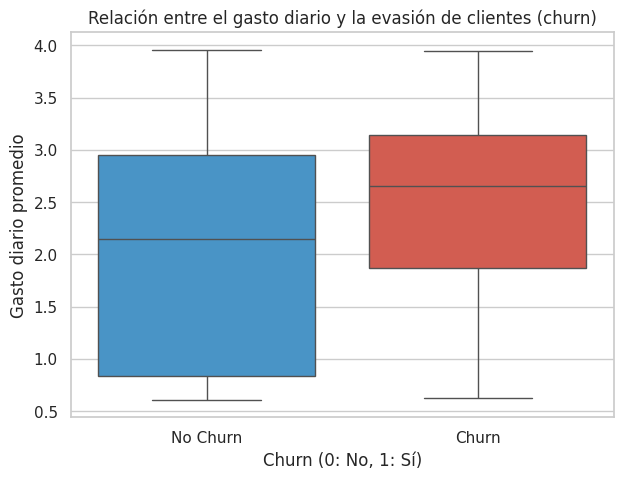

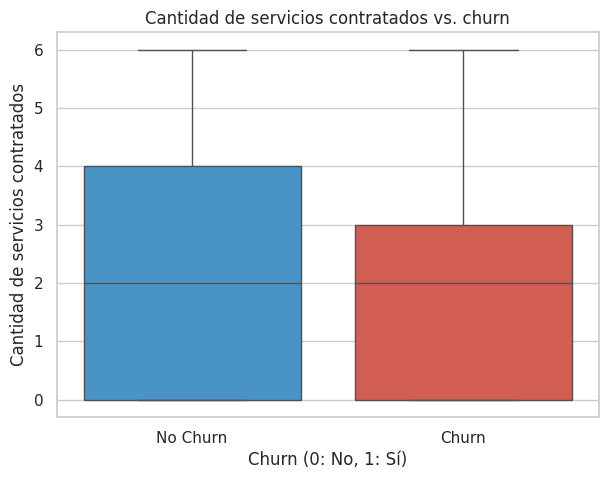

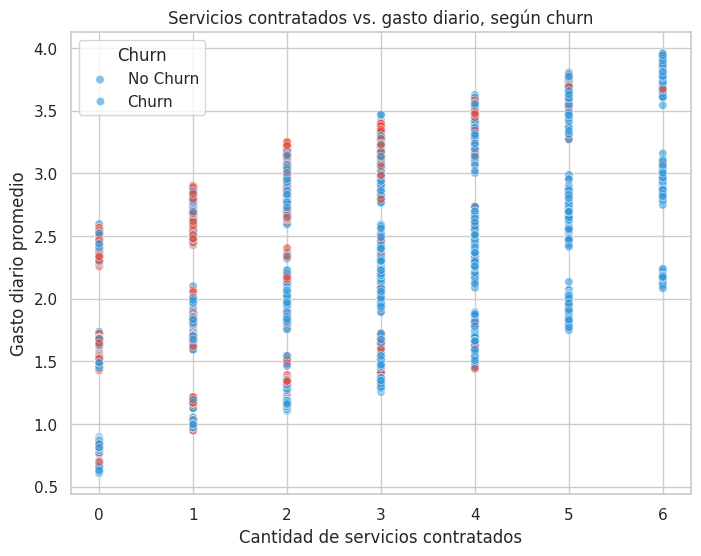

In [36]:
# Cálculo de la matriz de correlación para las variables numéricas relevantes
df_cleaned['churn'] = pd.to_numeric(df_cleaned['churn'], errors='coerce')
df_cleaned.dropna(subset=['churn'], inplace=True)


correlation_matrix = df_cleaned[['churn', 'charges_daily', 'tenure', 'charges_monthly', 'charges_total']].corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

# Análisis específico: relación entre el gasto diario y la evasión de clientes
plt.figure(figsize=(7, 5))
sns.boxplot(x='churn', y='charges_daily', data=df_cleaned, palette=['#3498db', '#e74c3c'])
plt.title('Relación entre el gasto diario y la evasión de clientes (churn)')
plt.xlabel('Churn (0: No, 1: Sí)')
plt.ylabel('Gasto diario promedio')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

# Análisis adicional: cantidad de servicios contratados y churn
# Se cuenta el número de servicios adicionales contratados por cada cliente
service_cols = [
    'onlinesecurity', 'onlinebackup', 'deviceprotection',
    'techsupport', 'streamingtv', 'streamingmovies'
]

for col in service_cols:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

df_cleaned['num_services'] = df_cleaned[service_cols].sum(axis=1)

plt.figure(figsize=(7, 5))
sns.boxplot(x='churn', y='num_services', data=df_cleaned, palette=['#3498db', '#e74c3c'])
plt.title('Cantidad de servicios contratados vs. churn')
plt.xlabel('Churn (0: No, 1: Sí)')
plt.ylabel('Cantidad de servicios contratados')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.show()

# Gráfico de dispersión: servicios contratados vs. gasto diario, coloreado por churn
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='num_services', y='charges_daily', hue='churn',
    data=df_cleaned, palette=['#3498db', '#e74c3c'], alpha=0.6
)
plt.title('Servicios contratados vs. gasto diario, según churn')
plt.xlabel('Cantidad de servicios contratados')
plt.ylabel('Gasto diario promedio')
plt.legend(title='Churn', labels=['No Churn', 'Churn'])
plt.show()

**Conclusión:**  
Se observa que los clientes con menor cantidad de servicios contratados y mayor gasto diario presentan una mayor tasa de evasión. Además, la matriz de correlación permite identificar qué variables están más asociadas al churn, lo que es clave para futuros modelos predictivos.